#### Project the rainfall in a file

In [2]:
import numpy as np
import pandas as pd
import datetime, yaml
import scipy.io as sio
import matplotlib.pyplot as plt

rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,20)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')  

### Build and check a rainfall CSV from the matlab output

In [ ]:
dept = ['Artibonite','Centre','Grande_Anse','Nippes','Nord','Nord-Est','Nord-Ouest','Ouest','Sud','Sud-Est']

def date_mat2py(matlab_datenum):
    return datetime.datetime.fromordinal(int(matlab_datenum)) + datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days = 366)

def timeseries_mat2py(data_mat, date_mat, columns):
    dates = []
    for ind, d in enumerate(date_mat):
        dates.append(date_mat2py(float(d)))
    return pd.DataFrame(data_mat.T, index=dates, columns = columns)

In [27]:
rainfall = sio.loadmat('prec_TRMM_GPM_daily_dept.mat')

In [28]:
rainfall = timeseries_mat2py(rainfall['R_dept_day'], rainfall['date_list'], dept)

In [29]:
rainfall.to_csv('rainfall_new.csv')

In [30]:
rainfall_old = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)

In [3]:
np.mean(rainfall.mean()/rainfall.max())

0.024847906589078546

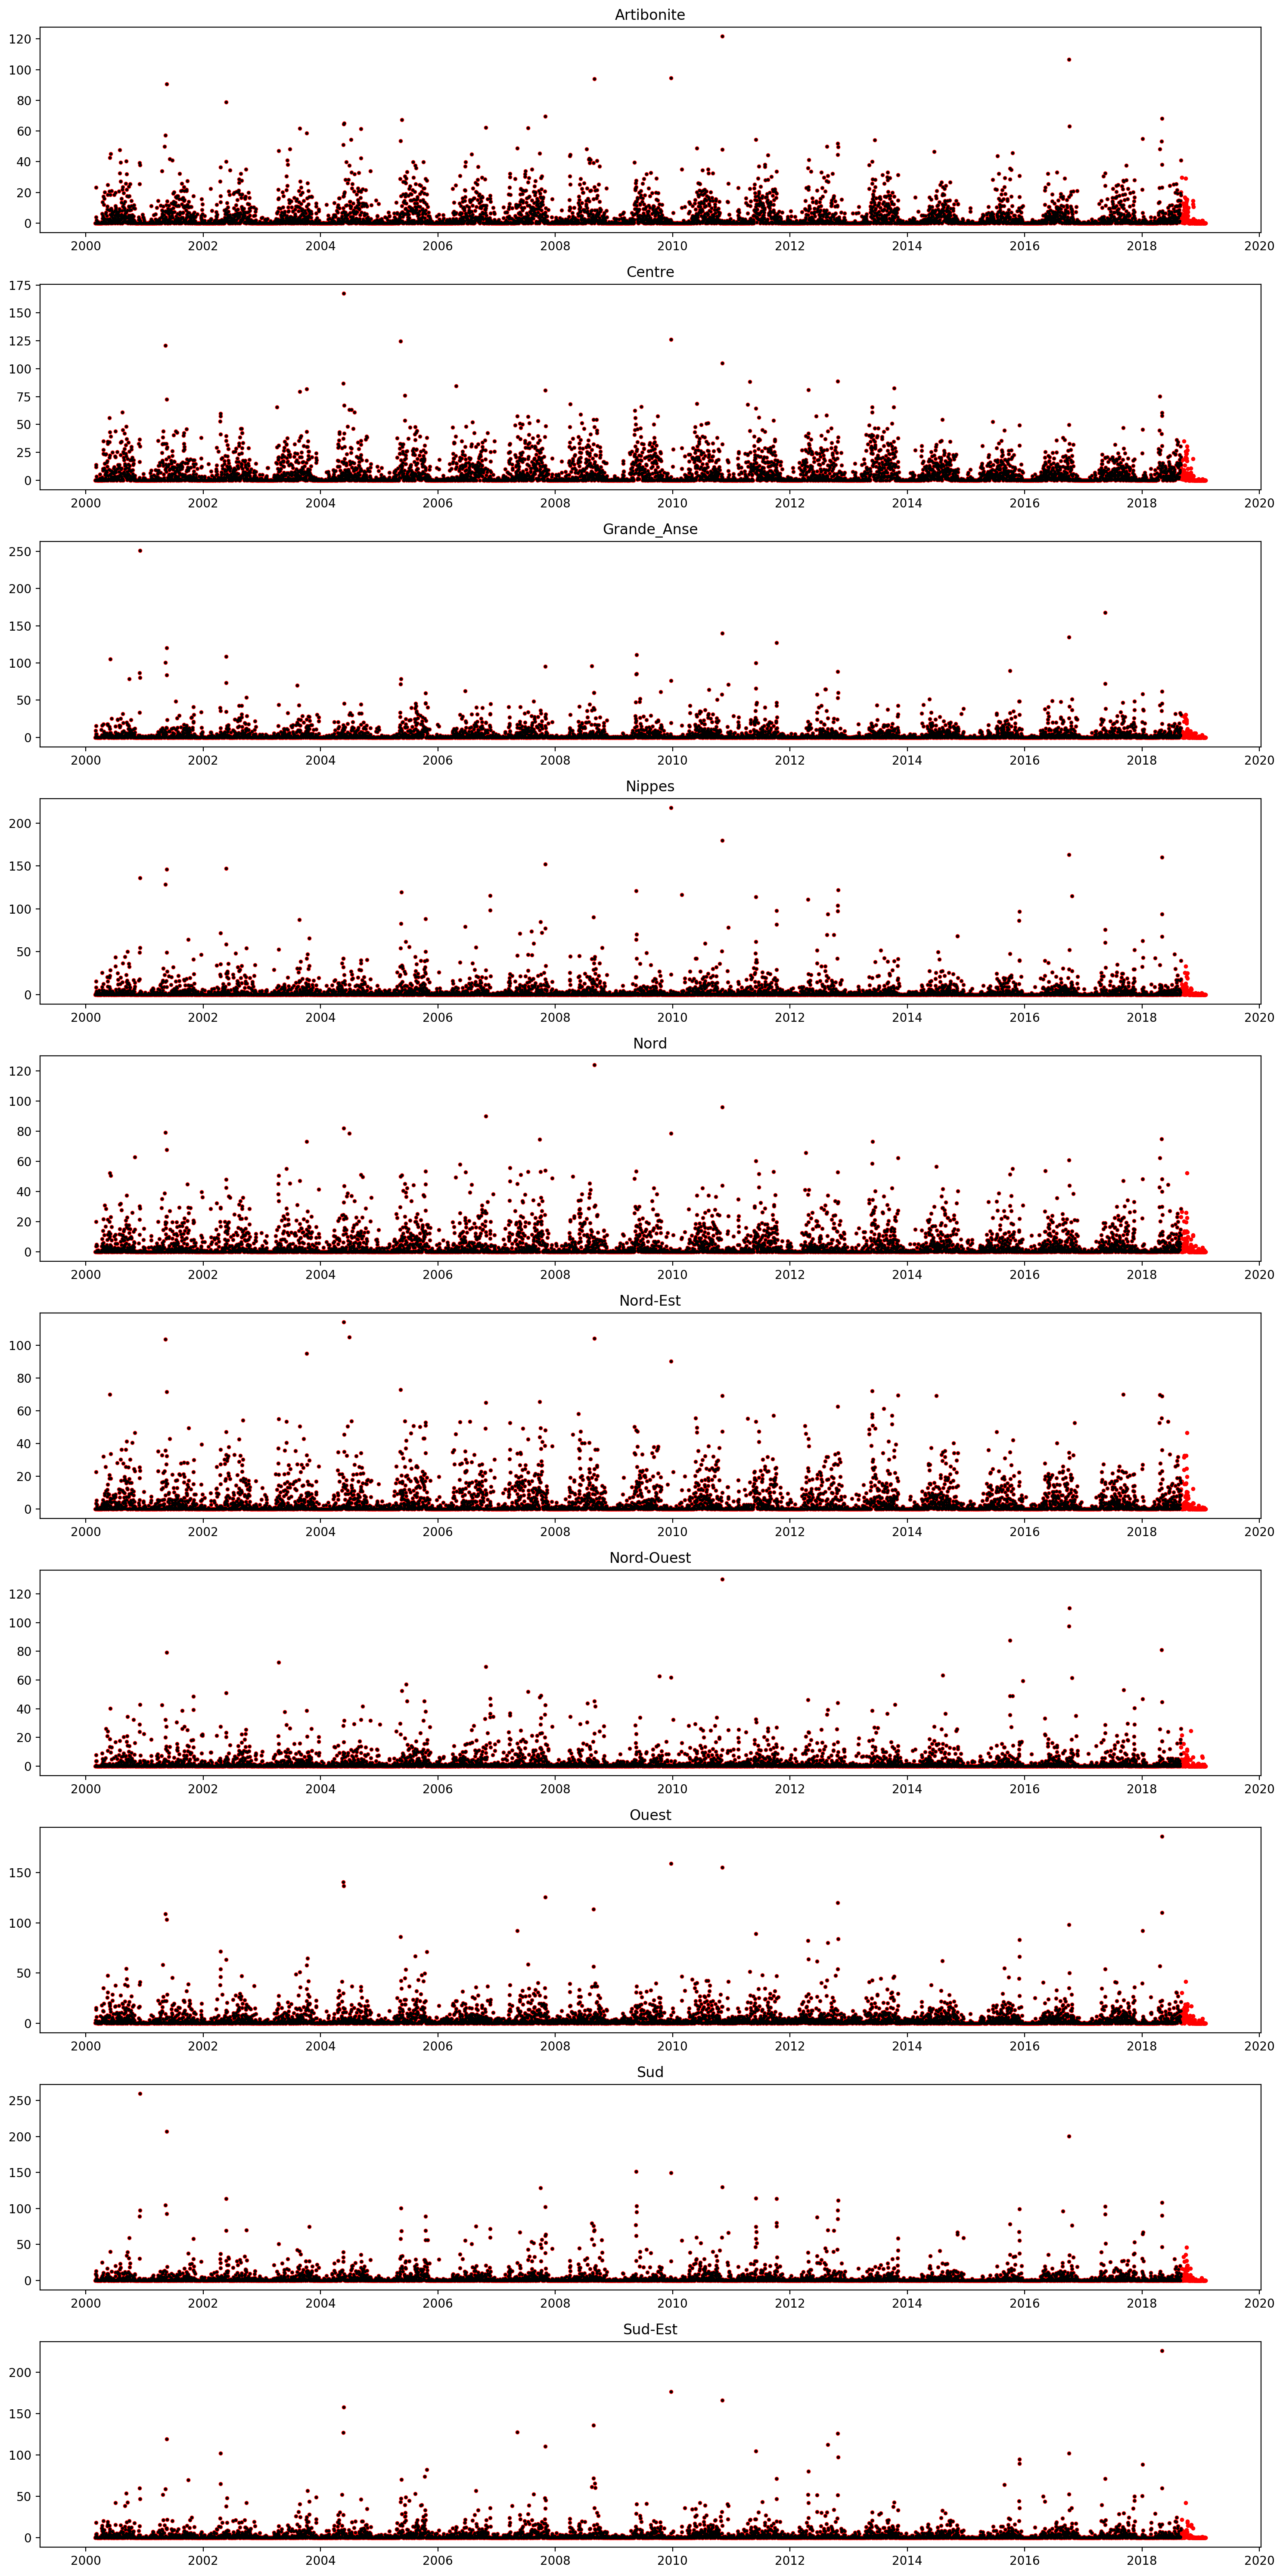

In [37]:
fig, axes = plt.subplots(10, 1, figsize=(15,30), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
for i, dp in enumerate(dept):

    axes[i].plot(rainfall[dp], marker='.', linestyle='',color='r', linewidth=1, markersize=5 )
    axes[i].plot(rainfall_old[dp], marker='.', linestyle='',color='k', linewidth=1, markersize=3 ) 

    axes[i].set_title(dp)

fig.tight_layout()